## Dataset summary
#### The dataset that we used was created through a detailed annotation process that followed the Columbia University Guidelines. Specifically, 500 reddit posts were annotated by four practicing psychiatrists with respect to the potential of the writers to commit suicide.
#### The labels follow the 5-class Suicide Severity Rating Scale with the following ordered classes: Supportive < Indicator < Ideation < Behavior < Attempt
#### Our  work focused on predicting the SSRS label based on the reddit posts using NLP and, specifically, LSTM neural network.

##### This notebook presents a brief summary of our work. In order to run it, the user needs to copy three specific files to the directory of the running script.
- 500_Reddit_users_posts_labels.csv (https://github.com/TheoEfthymiadis/Deep-Learning-NLP-Suicide-Severity-Rating-Scale-Assessment/blob/main/Data/500_Reddit_users_posts_labels.csv)
- embedding_matrix.csv (https://github.com/TheoEfthymiadis/Deep-Learning-NLP-Suicide-Severity-Rating-Scale-Assessment/blob/main/Data/embedding_matrix.csv)
- config7.json (https://github.com/TheoEfthymiadis/Deep-Learning-NLP-Suicide-Severity-Rating-Scale-Assessment/blob/main/Configurations/LSTM1/config7.json)

## Data exploration - preprocessing

In [17]:
#Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import os

from sklearn.model_selection import train_test_split

from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer

import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Maria\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [6]:
# Define the directory paths
root_dir = os.getcwd()

In [10]:
# Import the data
ssrs = pd.read_csv(os.path.join(root_dir, '500_Reddit_users_posts_labels.csv'))
print(ssrs.head())

     User                                               Post       Label
0  user-0  ['Its not a viable option, and youll be leavin...  Supportive
1  user-1  ['It can be hard to appreciate the notion that...    Ideation
2  user-2  ['Hi, so last night i was sitting on the ledge...    Behavior
3  user-3  ['I tried to kill my self once and failed badl...     Attempt
4  user-4  ['Hi NEM3030. What sorts of things do you enjo...    Ideation


In [11]:
# Check for any nulls values
ssrs.isnull().sum()

User     0
Post     0
Label    0
dtype: int64

Text(0.5, 1.0, 'Label Data Distribution')

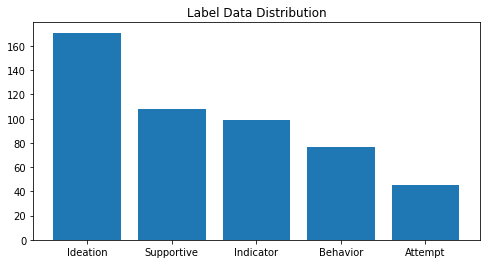

In [12]:
val_count = ssrs.Label.value_counts()

plt.figure(figsize=(8,4))
plt.bar(val_count.index, val_count.values)
plt.title("Label Data Distribution")

##### The distribution of the labels is imbalanced but we hope that the marginal effect on predictions will be limited

In [15]:
# Stemming of the Reddit Posts
english_stemmer = nltk.stem.SnowballStemmer('english')


def post_to_wordlist(post, remove_stopwords=True):
    # Function to convert a post to a sequence of words,
    # optionally removing stop words.  Returns a list of words.

    # 1. Remove non-letters
    post_text = re.sub("[^a-zA-Z]", " ", post)

    # 2. Convert words to lower case and split them
    words = post_text.lower().split()

    # 3. Optionally remove stop words (True by default)
    if remove_stopwords:
        stops = set(stopwords.words("english"))
        words = [w for w in words if not w in stops]

    b = []
    stemmer = english_stemmer  # PorterStemmer()
    for word in words:
        b.append(stemmer.stem(word))

    # 4. Return a list of stemmed words
    return b

In [18]:
# Using the post_to_wordlist function iteratively on all posts
clean = []
for post in ssrs['Post']:
    clean.append(" ".join(post_to_wordlist(post)))

In [19]:
# Join the cleaned posts with the corresponding labels in a new DF
ssrs_c = pd.DataFrame(clean, columns=['Post']).join(ssrs['Label'])

In [20]:
# Split Dataset into Training and Test data to be stored in different files
training_data, test_data = train_test_split(ssrs_c[['Post', 'Label']], test_size=0.2, stratify=ssrs_c[['Label']],
                                            random_state=6)

# Split Training Data into Training set and Validation set to be stored in different files
train_data, val_data = train_test_split(training_data[['Post', 'Label']], test_size=0.2,
                                        stratify=training_data[['Label']], random_state=6)

In [21]:
# Fitting a tokenizer on the Training Set to index the known vocabulary
tokenizer = Tokenizer(oov_token='OOV')
tokenizer.fit_on_texts(train_data['Post'])

##### The tokenizer was intentionally fit only on the training set, using the OOV token for unknown words. This way, our model will have the opportunity to learn how to handle unknown words, given that the validation set also contains words that are not present in the training set.

In [23]:
# Saving the size and the index of our vocabulary
word_index = tokenizer.word_index
vocab_size = len(tokenizer.word_index) + 1
print("Vocabulary Size :", vocab_size)

Vocabulary Size : 9211


In [24]:
# Not all posts have the same length. We need to address that through zero padding
MAX_SEQUENCE_LENGTH = max(pd.DataFrame(len(post.split()) for post in clean)[0])
print("Max Sequence Length :", MAX_SEQUENCE_LENGTH)

Max Sequence Length : 3183


In [25]:
# All posts are translated to sequences of numbers through the Tokenizer that was trained earlier
# Additionally, zero padding is applied so that all posts have the same length, equal to MAX_SEQUENCE_LENGTH
x_train = pad_sequences(tokenizer.texts_to_sequences(train_data['Post']), maxlen=MAX_SEQUENCE_LENGTH)
x_val = pad_sequences(tokenizer.texts_to_sequences(val_data['Post']), maxlen=MAX_SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(test_data['Post']), maxlen=MAX_SEQUENCE_LENGTH)

In [27]:
# Manual encoding of our labels due to their Ordinal Nature
y_train = np.where(train_data.Label == 'Supportive', 0,
                   np.where(train_data.Label == 'Indicator', 1,
                            np.where(train_data.Label == 'Ideation', 2,
                                     np.where(train_data.Label == 'Behavior', 3, 4))))
y_val = np.where(val_data.Label == 'Supportive', 0,
                 np.where(val_data.Label == 'Indicator', 1,
                          np.where(val_data.Label == 'Ideation', 2,
                                   np.where(val_data.Label == 'Behavior', 3, 4))))
y_test = np.where(test_data.Label == 'Supportive', 0,
                  np.where(test_data.Label == 'Indicator', 1,
                           np.where(test_data.Label == 'Ideation', 2,
                                    np.where(test_data.Label == 'Behavior', 3, 4))))

y_train = y_train.reshape(-1, 1)
y_val = y_val.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

## Word embeddings
#### imported from Glove: the file with pretained embeddings was too large to include it here.  Therefore, the corresponding code blocks have been commented out and we import the final output of this process stored in the embedding_matrix.csv file

In [ ]:
# Importing a set of pretrained word embeddings from the Glove project and tuning them to our vocabulary
#embeddings_index = {}   # Dictionary to store the vocabulary and embeddings of Glove

#tic = time.time()   # Time variable to check the import speed

# Reading the file from glove.
#f = open(os.path.join(data_dir, 'glove.42B.300d.txt'), encoding="utf8")
#for line in f:
#    values = line.split()
#    word = value = values[0]
#    coefs = np.asarray(values[1:], dtype='float32')
#    embeddings_index[word] = coefs
#f.close()

# Print the number of embeddings that were imported
#print(f'loaded {len(embeddings_index)} word vectors from GloVe in {time.time()-tic} seconds')

In [28]:
# After importing the word embeddings, we want to see what part of our vocabulary is covered by GloVe
def check_coverage(vocab, embeddings_index):
    # This function compares a vocabulary against an word frequency dictionary to find the coverage
    # Prints the coverage and returns the frequency dictionary sorted in descending order
    a = {}
    oov = {}
    k = 0
    i = 0
    for word in vocab:
        try:
            a[word] = embeddings_index[word]
            k += vocab[word]
        except:

            oov[word] = vocab[word]
            i += vocab[word]
            pass

    print('Found embeddings for {:.2%} of training vocab'.format(len(a) / len(vocab)))
    print('Found embeddings for  {:.2%} of all training text'.format(k / (k + i)))
    sorted_x = sorted(oov.items(), key=operator.itemgetter(1))[::-1]

    return sorted_x


def build_vocab(sentences):
    """
    :param sentences: list of list of words
    :return: dictionary of words and their count
    """
    vocab = {}
    for sentence in sentences:
        for word in sentence:
            try:
                vocab[word] += 1
            except KeyError:
                vocab[word] = 1
    return vocab

In [30]:
# Count the word frequencies in our vocabulary
#vocab = build_vocab(list(train_data['Post'].apply(lambda x: x.split())))

# Calculating the coverage and sorting the word frequency dictionary
#oov = check_coverage(vocab, embeddings_index)

# We now join the dictionary containing the embeddings from GloVe with our vocabulary to only keep the ones we need
#EMBEDDING_DIM = 300   # This is the length of the embedding vectors provided by the specific GloVe file

#embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIM))   # This will be the matrix to store the final embeddings
#for word, i in word_index.items():
#    embedding_vector = embeddings_index.get(word)
#    if embedding_vector is not None:
#        embedding_matrix[i] = embedding_vector

In [39]:
# Import the embedding_matrix
embedding_matrix = pd.read_csv(os.path.join(root_dir, 'embedding_matrix.csv'))

## LSTM model Architecture and Configuration

In [44]:
# Importing Libraries
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix
import json
import sys

In [33]:
# Setting tensorflow seed for reproducibility
tf.random.set_seed(0)

#### In this section, we will build, configure and train a LSTM model with the following achitecture

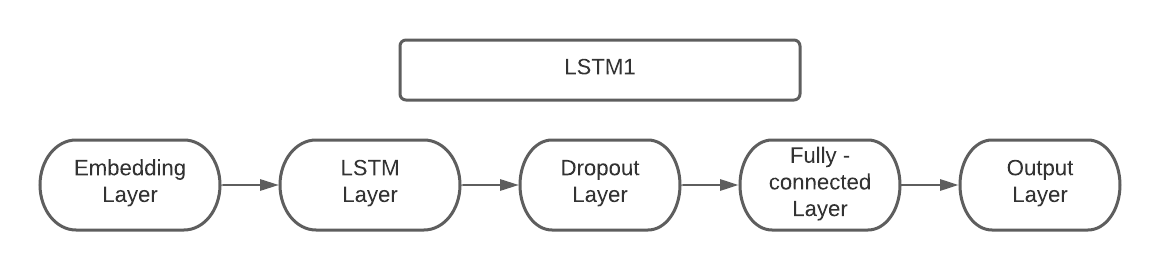

### Model configuration

In [41]:
# ### Constant Parameters ###
max_sequence_length = 3183
verbosity_mode = 1
EMBEDDING_DIM = 300
vocab_size = len(embedding_matrix)

In [35]:
# Creating the configuration file path
config = 'config7.json'
config_path = os.path.join(root_dir,config)

# Read configuration file
with open(config_path) as json_data_file:
    config_data = json.load(json_data_file)   # Dictionary to store the configuration parameters

In [36]:
#Read the model parameters from the configuration file
batch_size = int(config_data["batch_size"])
number_of_epochs = int(config_data["number_of_epochs"])
optimizer = 'rmsprop'
LSTM1_units = int(config_data["LSTM1_units"])
LSTM1_drop = float(config_data["LSTM1_drop"])
LSTM1_rec_drop = float(config_data["LSTM1_rec_drop"])
Dense1_units = int(config_data["Dense1_units"])
Dense1_act = config_data["Dense1_act"]
Dropout1 = float(config_data["Dropout1"])

In [37]:
# Disable eager execution
tf.compat.v1.disable_eager_execution()

### Model building

In [40]:
# Define the Keras model
model = Sequential()

# Embedding Layer
model.add(tf.keras.layers.Embedding(vocab_size,
                                    EMBEDDING_DIM,
                                    weights=[embedding_matrix],
                                    input_length=max_sequence_length,
                                    trainable=False))
# 1st LSTM Layer
model.add(LSTM(LSTM1_units, dropout=LSTM1_drop, recurrent_dropout=LSTM1_rec_drop, return_sequences=False,
               input_shape=(max_sequence_length, vocab_size)))
# 1st Dropout Layer
model.add(Dropout(Dropout1))

# 1st Dense Layer
model.add(Dense(units=Dense1_units, activation=Dense1_act))

# Output Layer
model.add(Dense(units=1, activation='linear'))

# Compile the model
model.compile(optimizer=optimizer, loss='mse')

# Give a summary of the model
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 3183, 300)         2763300   
_________________________________________________________________
lstm (LSTM)                  (None, 12)                15024     
_________________________________________________________________
dropout (Dropout)            (None, 12)                0         
_________________________________________________________________
dense (Dense)                (None, 6)                 78        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 7         
Total params: 2,778,409
Trainable params: 15,109
Non-trainable params: 2,763,300
_________________________________________________________________


In [45]:
# Model callbacks

# Defining the Learning Rate decay
ReduceLROnPlateau = ReduceLROnPlateau(factor=0.1, min_lr=0.01, monitor='loss', verbose=1)

# Creating a checkpoint callback to export the best model of the training phase
checkpoint_filepath = os.path.join(root_dir, 'Checkpoint')
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
     filepath=checkpoint_filepath,
     save_weights_only=False,
     monitor='val_loss',
     mode='min',
     save_best_only=True)

### Implementation of the CEM (Closeness Evaluation Measure)

In [47]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix
import math
import keras

#This class will allow us to plot CEM calculated on the validation set at the end of each training epoch. 
class CEM(keras.callbacks.Callback):

    def __init__(self, train, validation=None):
        super(CEM, self).__init__()
        self.validation = validation
        self.train = train

    def on_epoch_end(self, epoch, logs={}):

        X_valid, y_valid = self.validation[0], self.validation[1]
        y_pred = np.asarray(self.model.predict(X_valid))
        
        #Round the regression outputs to represent classes
        y_pred_cat=y_pred.round(0).astype(int)
        y_predict_cat=y_pred_cat.reshape(-1,1)
        
        #Calculate the confusion matrix
        matrix=(metrics.confusion_matrix(y_valid, y_predict_cat,labels=[0,1,2,3,4]))
        
        #Calculation of the CEM
        mat=pd.DataFrame(matrix)
        mat.loc['Total'] = pd.Series(mat.sum())
        mat['Total'] = mat.sum(axis=1)
        class_proxim=pd.DataFrame(np.zeros((len(mat)-1, len(mat)-1)))
        ttl=mat.iloc[-1,-1]
        for row in range(0, len(mat)-1):
            for column in range(0, len(mat.columns)-1):
                if row==column:
                    if mat.iloc[-1,column]==0:
                        class_proxim.iloc[row,column]=0.0000001
                    else:
                        class_proxim.iloc[row,column]=-math.log2((mat.iloc[-1,column]/2)/ttl)
                elif abs(row-column)==1:
                    if mat.iloc[-1,row]/2+mat.iloc[-1,column]==0:
                        class_proxim.iloc[row,column]=0.0000001
                    else:
                        class_proxim.iloc[row,column]=-math.log2((mat.iloc[-1,row]/2+mat.iloc[-1,column])/ttl)
                elif abs(row-column)==2:
                    if row>column:
                        if mat.iloc[-1,row]/2+mat.iloc[-1,row-1]+mat.iloc[-1,column]==0:
                            class_proxim.iloc[row,column]=0.0000001
                        else:
                            class_proxim.iloc[row,column]=-math.log2((mat.iloc[-1,row]/2+mat.iloc[-1,row-1]+mat.iloc[-1,column])/ttl)
                    else:
                        if mat.iloc[-1,row]/2+mat.iloc[-1,column-1]+mat.iloc[-1,column]==0:
                            class_proxim.iloc[row,column]=0.0000001
                        else:
                            class_proxim.iloc[row,column]=-math.log2((mat.iloc[-1,row]/2+mat.iloc[-1,column-1]+mat.iloc[-1,column])/ttl)
                elif abs(row-column)==3:
                    if row>column:
                        if mat.iloc[-1,row]/2+mat.iloc[-1,row-2]+mat.iloc[-1,row-1]+mat.iloc[-1,column]==0:
                            class_proxim.iloc[row,column]=0.0000001
                        else:
                            class_proxim.iloc[row,column]=-math.log2((mat.iloc[-1,row]/2+mat.iloc[-1,row-2]+mat.iloc[-1,row-1]+mat.iloc[-1,column])/ttl)
                    else:
                        if mat.iloc[-1,row]/2+mat.iloc[-1,column-2]+mat.iloc[-1,column-1]+mat.iloc[-1,column]==0:
                            class_proxim.iloc[row,column]=0.0000001
                        else:
                            class_proxim.iloc[row,column]=-math.log2((mat.iloc[-1,row]/2+mat.iloc[-1,column-2]+mat.iloc[-1,column-1]+mat.iloc[-1,column])/ttl)
                elif abs(row-column)==4:
                    if row>column:
                        if mat.iloc[-1,row]/2+mat.iloc[-1,row-3]+mat.iloc[-1,row-2]+mat.iloc[-1,row-1]+mat.iloc[-1,column]==0:
                            class_proxim.iloc[row,column]=0.0000001
                        else:
                            class_proxim.iloc[row,column]=-math.log2((mat.iloc[-1,row]/2+mat.iloc[-1,row-3]+mat.iloc[-1,row-2]+mat.iloc[-1,row-1]+mat.iloc[-1,column])/ttl)
                    else:
                        if mat.iloc[-1,row]/2+mat.iloc[-1,column-3]+mat.iloc[-1,column-2]+mat.iloc[-1,column-1]+mat.iloc[-1,column]==0:
                            class_proxim.iloc[row,column]=0.0000001
                        else:
                            class_proxim.iloc[row,column]=-math.log2((mat.iloc[-1,row]/2+mat.iloc[-1,column-3]+mat.iloc[-1,column-2]+mat.iloc[-1,column-1]+mat.iloc[-1,column])/ttl)
        cem_=mat.iloc[:-1,:-1].mul(class_proxim)
        numerator=cem_.to_numpy().sum()
        denominator=0
        for column in range(0, len(mat)-1):
            denom=mat.iloc[-1,column]*class_proxim.iloc[column,column]
            denominator=denominator+denom
        cem=numerator/denominator
        print(" CEM:",cem)
        return(cem)

### Model training

#### The following cell has been executed to train the model just for 5 epochs in order to illustrate some indicative results and, especially, the output of the customized evaluation metric CEM at the end of each training epoch.

In [48]:
# Fetching features and labels for the training process
train_data_n = np.c_[x_train, y_train]
valid_data_n = np.c_[x_val, y_val]

# Training the model and storing the history
history = model.fit(train_data_n[:, :-1], train_data_n[:, -1], batch_size=batch_size, epochs=number_of_epochs,
                    verbose=verbosity_mode, shuffle=True, validation_data=(valid_data_n[:, :-1], valid_data_n[:, -1]),
                    callbacks=[EarlyStopping(monitor='val_loss', patience=5), model_checkpoint_callback,
                               ReduceLROnPlateau,CEM(train=(train_data_n[:,:-1],train_data_n[:,-1]),validation=(valid_data_n[:,:-1],valid_data_n[:,-1]))])

Train on 320 samples, validate on 80 samples
Epoch 1/5
320/320 [==============================] - ETA: 0s - loss: 3.0271 

C:\Users\Maria\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


INFO:tensorflow:Assets written to: C:\Checkpoint\assets


C:\Users\Maria\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


 CEM: 0.2
320/320 [==============================] - 158s 493ms/sample - loss: 3.0271 - val_loss: 2.3208
Epoch 2/5
320/320 [==============================] - ETA: 0s - loss: 2.1781 INFO:tensorflow:Assets written to: C:\Checkpoint\assets
 CEM: 0.2
320/320 [==============================] - 160s 501ms/sample - loss: 2.1781 - val_loss: 1.8538
Epoch 3/5
320/320 [==============================] - ETA: 0s - loss: 1.7814 INFO:tensorflow:Assets written to: C:\Checkpoint\assets
 CEM: 0.3528507966690242
320/320 [==============================] - 200s 624ms/sample - loss: 1.7814 - val_loss: 1.6334
Epoch 4/5
320/320 [==============================] - ETA: 0s - loss: 1.5926 INFO:tensorflow:Assets written to: C:\Checkpoint\assets
 CEM: 0.392427370689648
320/320 [==============================] - 182s 568ms/sample - loss: 1.5926 - val_loss: 1.5267
Epoch 5/5
320/320 [==============================] - ETA: 0s - loss: 1.5385 INFO:tensorflow:Assets written to: C:\Checkpoint\assets
 CEM: 0.379045389299085

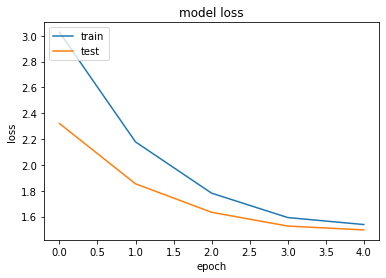

In [50]:
# Plot a training-validation loss over epochs plot
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [52]:
# Importing the best model
imported_model = tf.keras.models.load_model(os.path.join(root_dir,'Checkpoint'))

In [54]:
# Prediction using the imported model
y_estimate = imported_model.predict(x_test)

# Round the regression outputs to represent classes
for index, element in enumerate(y_estimate):
    element[0] = round(element[0])

In [56]:
y_pred_cat = y_estimate.astype(int)
y_predict_cat = y_pred_cat.reshape(-1, 1)

# Calculate the confusion matrix
matrix = (metrics.confusion_matrix(y_test, y_predict_cat, labels=[0, 1, 2, 3, 4]))
matrix

array([[ 0,  7, 15,  0,  0],
       [ 0,  7, 13,  0,  0],
       [ 0,  9, 25,  0,  0],
       [ 0,  3, 12,  0,  0],
       [ 0,  2,  7,  0,  0]], dtype=int64)

In [59]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
accuracy = accuracy_score(y_test, y_estimate)
print('Accuracy = ', accuracy)

f1_score = f1_score(y_test, y_estimate, average='macro',)
print('Macro Average F1 = ', f1_score)

Accuracy =  0.32
Macro Average F1 =  0.15267295597484276


## Discussion

- All models converge to val_loss=1.5. It seems that there is not much to learn under this LSTM setting. Essentially, models learn to predict every test set instance within the classes 1(indicator) and 2 (ideation). 
- As we make models more complex to learn better, we transition to overfitting
- Maybe DL is not the right way to go. We would need way more data.
- We could use subsampling to do our model more robust, but we have a really small minority class.
- We could use simpler embeddings, or perhaps even train our own. 
- We should explore ML algorithms (such as Naive Bayes and SVM)